In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re
import itertools

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

### Load validation predicted probabilities

In [4]:
main_dir = '/tf/notebooks/'

In [5]:
probs_path = main_dir+'final-project/Classification/data/age'

In [6]:
test_pred_probs_mlp_ngram = np.load(os.path.join(probs_path, 'test_pred_probs_mlp_ngram.npy'))
test_pred_probs_cnn = np.load(os.path.join(probs_path, 'test_pred_probs_cnn.npy'))
test_pred_probs_cnn_aggr_chunk = np.load(os.path.join(probs_path, 'test_pred_probs_cnn_aggr_chunk.npy'))

In [7]:
len(test_pred_probs_mlp_ngram), len(test_pred_probs_cnn), len(test_pred_probs_cnn_aggr_chunk)

(76352, 76352, 76352)

In [8]:
with open(os.path.join(probs_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(probs_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)
with open(os.path.join(probs_path, 'test_list'), 'rb') as fp:
    test_list = pickle.load(fp)

In [9]:
len(test_ids), len(test_target), len(test_list)

(76352, 76352, 76352)

In [38]:
descr_df = pd.read_csv(main_dir+'final-project/data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(test_ids, dtype=int)]
descr_df.reset_index(inplace=True)
descr_df.drop_duplicates('speech_id', inplace=True)
descr_df.shape

(76352, 17)

In [39]:
pred_df = pd.DataFrame({'ids': np.asarray(test_ids, dtype=np.int64), 
                        'pred_probs_mlp_ngram': test_pred_probs_mlp_ngram.flatten(), 
                        'pred_probs_cnn': test_pred_probs_cnn.flatten(),
                        'pred_probs_cnn_chunk': test_pred_probs_cnn_aggr_chunk.flatten()})
pred_df.shape

(76352, 4)

In [19]:
pred_df.head()

,ids,pred_probs_cnn,pred_probs_cnn_chunk,pred_probs_mlp_ngram
0,1050182087,0.597515,0.510988,0.434472
1,1020096707,0.721381,0.553838,0.661349
2,1120051071,0.430836,0.569507,0.585980
3,970125650,0.555040,0.517367,0.440294
4,980064867,0.749540,0.578491,0.628577


In [40]:
descr_pred_df = descr_df.merge(pred_df, left_on='speech_id', right_on='ids')
descr_pred_df.shape

(76352, 21)

In [41]:
preds = [
    'pred_probs_mlp_ngram',
    'pred_probs_cnn', 
    'pred_probs_cnn_chunk'
]

In [42]:
descr_pred_df[preds+['Age_lt_med']].groupby('Age_lt_med').mean()

,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
Age_lt_med,,,
0.0,0.424971,0.449423,0.472116
1.0,0.579270,0.567301,0.527728


In [43]:
descr_pred_df['pred_probs_combo'] = descr_pred_df[preds].mean(axis=1)
descr_pred_df['pred_combo'] = descr_pred_df['pred_probs_combo'] > 0.5
np.mean(test_target==descr_pred_df['pred_combo'])

0.6540758591785415

### Save the main dataframe

In [44]:
keep_cols = ['speech_id',
 'date',
 'char_count',
 'word_count',
 'speakerid',
 'Party',
 'Congress',
 'Chamber',
 'State',
 'Ethnicity',
 'Age',
 'Age_lt_med',
 'NonWhite',
 'Female',
 'speaker',
 'Full Name',
 'match',
 'ids',
 'pred_probs_combo',
 'pred_combo']

In [45]:
descr_pred_df[keep_cols].to_pickle(os.path.join(probs_path, 'test_age_preds.pkl'))

### Evaluating final predictions

In [46]:
classes = ['Old', 'Young']

Confusion matrix, without normalization
[[23802 14374]
 [12038 26138]]
              precision    recall  f1-score   support

         Old       0.66      0.62      0.64     38176
       Young       0.65      0.68      0.66     38176

   micro avg       0.65      0.65      0.65     76352
   macro avg       0.65      0.65      0.65     76352
weighted avg       0.65      0.65      0.65     76352



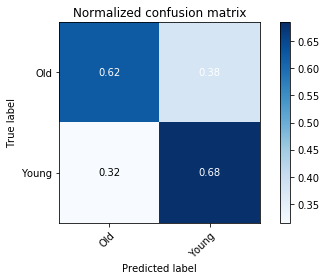

In [47]:
explore_data.plot_confusion_matrix(test_target, descr_pred_df['pred_combo'], classes, normalize=True)

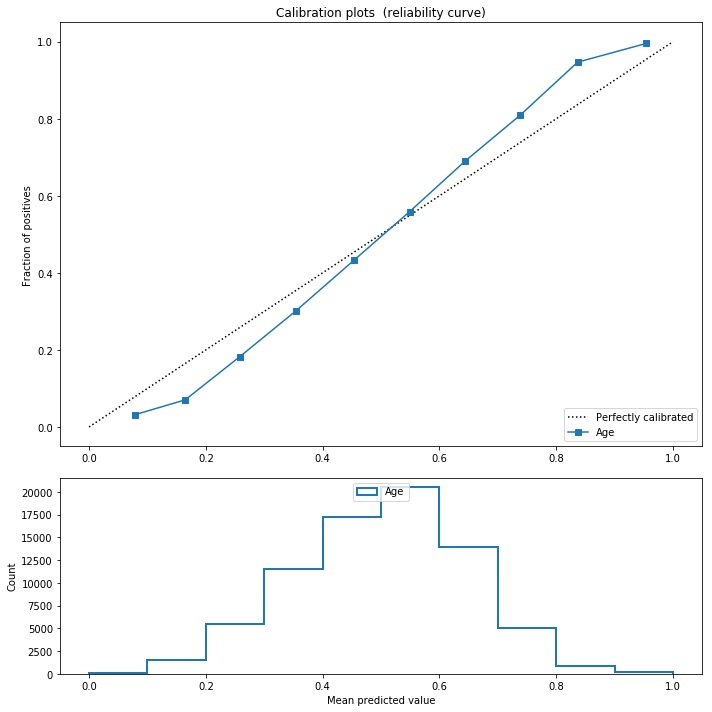

In [48]:
explore_data.plot_calibration_curve(test_target, descr_pred_df['pred_probs_combo'], 'Age')

In [49]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(descr_pred_df['pred_probs_combo'], 
                                   test_ids, 
                                   descr_df.set_index('speech_id'))

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge  Party_D  Chamber_H  AvgWordCount
base  0.095295       0.095217  55.879466  0.52609    0.62094     376.23317


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.57,0.61,1.10,1.00,0.24,0.95
0.6,1.14,1.14,1.00,1.04,1.11,1.05
1.0,1.13,1.11,0.91,0.92,1.50,0.96


In [50]:
reload(explore_data)
explore_data.compare_ngrams(test_list, descr_pred_df['pred_probs_combo'], 
                            ngram_range=(1, 1),
                            top_k=20)


Top 20 ngrams by differentiating score:


,ngram,<0.4,<0.6,<1.0,score
0,unanimous,4735.0,3056.0,398.0,2631.0
1,senators,5141.0,2878.0,407.0,1403.0
2,distinguished,4165.0,3804.0,1265.0,694.0
3,proceed,1614.0,768.0,206.0,655.0
4,yielding,335.0,2111.0,2018.0,574.0
5,leader,4016.0,3275.0,1304.0,550.0
6,session,1811.0,1076.0,421.0,540.0
7,printed,1634.0,1718.0,228.0,500.0
8,quorum,722.0,338.0,63.0,403.0
9,authorized,1597.0,1369.0,343.0,350.0


## Congressperson level analysis

In [57]:
speaker_df = descr_pred_df[['Full Name', 'Party', 'State', 'Female', 'NonWhite', 'Age', 'Age_lt_med', 'pred_probs_combo']]\
                .groupby(['Full Name', 'Party', 'State', 'Female', 'NonWhite', 'Age_lt_med'])\
                .agg({'pred_probs_combo':['mean', 'count'], 'Age': ['mean']})\
                .reset_index()
speaker_df.columns = ['_'.join(col) for col in speaker_df.columns]
speaker_df['Age_lt_med_pred_'] = speaker_df.pred_probs_combo_mean > 0.5
speaker_df.shape

(2207, 10)

Confusion matrix, without normalization
[[ 327  675]
 [ 153 1052]]
              precision    recall  f1-score   support

         Old       0.68      0.33      0.44      1002
       Young       0.61      0.87      0.72      1205

   micro avg       0.62      0.62      0.62      2207
   macro avg       0.65      0.60      0.58      2207
weighted avg       0.64      0.62      0.59      2207



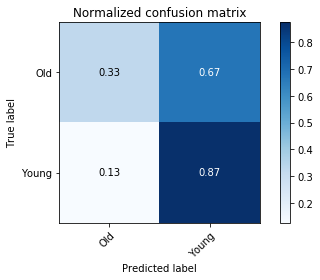

In [58]:
explore_data.plot_confusion_matrix(speaker_df.Age_lt_med_, speaker_df.Age_lt_med_pred_, classes, normalize=True)

In [59]:
speaker_df.pred_probs_combo_count.median()

17.0

In [60]:
speaker_med_df = speaker_df[speaker_df.pred_probs_combo_count > speaker_df.pred_probs_combo_count.median()]
speaker_med_df.shape

(1102, 10)

Confusion matrix, without normalization
[[219 287]
 [ 93 503]]
              precision    recall  f1-score   support

         Old       0.70      0.43      0.54       506
       Young       0.64      0.84      0.73       596

   micro avg       0.66      0.66      0.66      1102
   macro avg       0.67      0.64      0.63      1102
weighted avg       0.67      0.66      0.64      1102



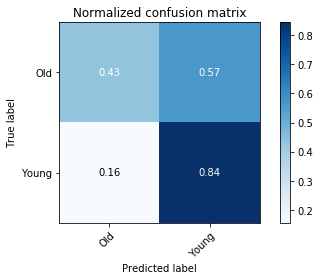

In [61]:
explore_data.plot_confusion_matrix(speaker_med_df.Age_lt_med_, speaker_med_df.Age_lt_med_pred_, classes, normalize=True)

In [62]:
tp = np.argmax(speaker_med_df[speaker_med_df.Age_lt_med_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Age_lt_med_==1].iloc[tp]

Full Name_                GRAVES, SAM
Party_                              R
State_                             MO
Female_                             0
NonWhite_                           0
Age_lt_med_                         1
pred_probs_combo_mean         0.90383
pred_probs_combo_count            106
Age_mean                      44.9057
Age_lt_med_pred_                 True
Name: 830, dtype: object

In [63]:
tn = np.argmin(speaker_med_df[speaker_med_df.Age_lt_med_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Age_lt_med_==0].iloc[tn]

Full Name_                BAKER, HOWARD
Party_                                R
State_                               TN
Female_                               0
NonWhite_                             0
Age_lt_med_                           0
pred_probs_combo_mean          0.230655
pred_probs_combo_count              523
Age_mean                        58.0172
Age_lt_med_pred_                  False
Name: 66, dtype: object

In [64]:
fp = np.argmax(speaker_med_df[speaker_med_df.Age_lt_med_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Age_lt_med_==0].iloc[fp]

Full Name_                SMITH, NICK
Party_                              R
State_                             MI
Female_                             0
NonWhite_                           0
Age_lt_med_                         0
pred_probs_combo_mean        0.619937
pred_probs_combo_count             33
Age_mean                      64.6667
Age_lt_med_pred_                 True
Name: 1918, dtype: object

In [65]:
fn = np.argmin(speaker_med_df[speaker_med_df.Age_lt_med_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Age_lt_med_==1].iloc[fn]

Full Name_                DOMENICI, PETE
Party_                                 R
State_                                NM
Female_                                0
NonWhite_                              0
Age_lt_med_                            1
pred_probs_combo_mean           0.346205
pred_probs_combo_count                57
Age_mean                              50
Age_lt_med_pred_                   False
Name: 570, dtype: object

## Congress level analysis

In [66]:
congress_df = descr_pred_df[['Congress', 'Age_lt_med', 'Age', 'pred_probs_combo', 'pred_combo']]\
                .groupby('Congress')\
                .agg({'Age_lt_med': ['mean', 'sum'], 'pred_combo': ['mean'], 'Age': ['mean']})\
                .reset_index()
congress_df.columns = ['_'.join(col) for col in congress_df.columns]
congress_df['Prediction_balance'] = congress_df.pred_combo_mean / congress_df.Age_lt_med_mean
congress_df.shape

(18, 6)

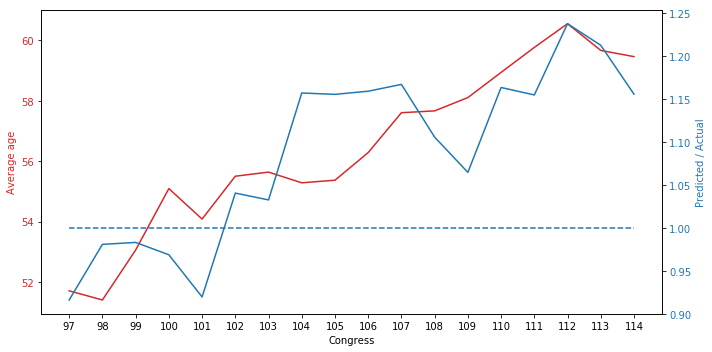

In [67]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Average age', color=color)
ax1.plot(congress_df.Congress_, congress_df.Age_mean, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predicted / Actual', color=color)  # we already handled the x-label with ax1
ax2.plot(congress_df.Congress_, congress_df.Prediction_balance, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.hlines(y=1,xmin=97,xmax=114, color=color, linestyles='dashed')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(range(97,115))
plt.show()